First draft...

Need to be improved

**Upvotes appreciated :)**

**Steps:**
1. Train model on anchor,positive,negative image sets to minimize triplet loss
2. Use trained model layers to generate embeddings of test images and index images
3. Train KNN classifier on index image embeddings (n=100)
4. Predict on test image embeddings (i.e. find test image embeddings' closest index image embedding) 
5. Save Model

https://towardsdatascience.com/image-similarity-using-triplet-loss-3744c0f67973

Trying Triplet Loss
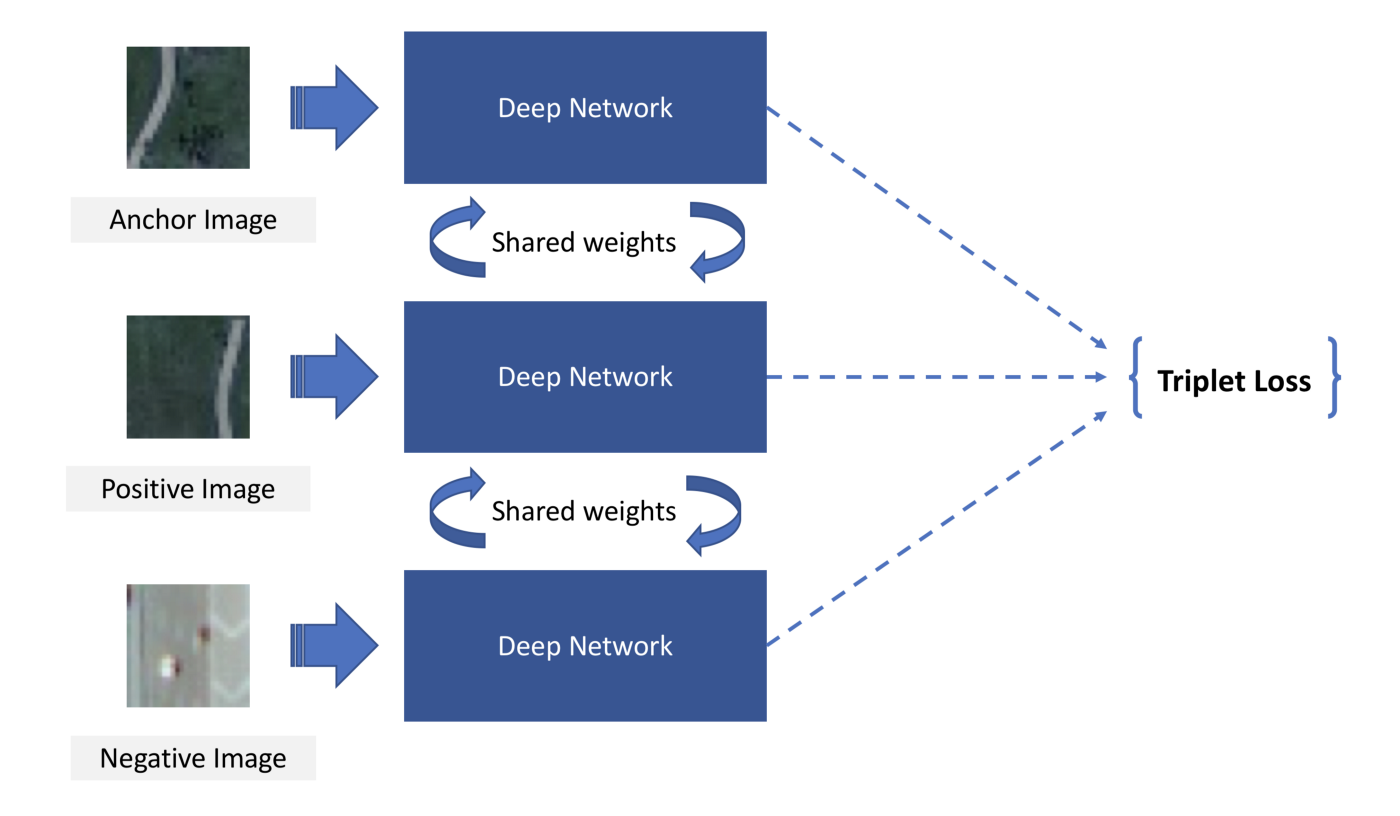

Inspired by: https://www.kaggle.com/c/landmark-retrieval-challenge/discussion/58155

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
train=pd.read_csv("/kaggle/input/landmark-retrieval-2020/train.csv")
train.head()

In [ ]:
train["landmark_id"].nunique(),train["id"].nunique(),train.shape

**Selecting only high occurrence landmarks for training**

In [ ]:
t=train.groupby("landmark_id")["id"].count().to_frame().sort_values("id",ascending=False)
t=t[t["id"]>100]
train=train[train["landmark_id"].isin(list(t.index))]
train["landmark_id"].nunique(),train["id"].nunique(),train.shape

In [ ]:
from glob import glob
train_files=glob("../input/landmark-retrieval-2020/train/*/*/*/*")
index_files=glob("../input/landmark-retrieval-2020/index/*/*/*/*")
test_files=glob("../input/landmark-retrieval-2020/test/*/*/*/*")
len(train_files),len(index_files),len(test_files)

In [ ]:
t=pd.DataFrame({"train_path":train_files})
t["id"]=t["train_path"].apply(lambda x: x.split("/")[-1][:-4])
train=train.merge(t,how='inner',on=["id"])
print(train.shape)
train.head()

In [ ]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
id=27
dfsample = train[train['landmark_id' ]== id]

for i,row in dfsample.reset_index().iterrows():
    
    path=row["train_path"]
    example = cv2.imread(path)
    print(example.shape)

    plt.imshow(example)
    plt.show()
    if (i>4):
        break

In [ ]:
train.head()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,models
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,train):
        self.batch_size=BATCH_SIZE
        self.landmark_ids=train["landmark_id"].unique()
        self.ids=train["id"].unique()
        
        self.dict_image_to_landmark_mapping=train.set_index("id")["landmark_id"].to_dict()
        self.dict_landmark_to_images_mapping=train.groupby("landmark_id")["id"].apply(list).to_dict()
        self.path_dict=train.set_index("id")["train_path"].to_dict()
        
        self.on_epoch_end()
        pass
    def __len__(self,):
#         return int(np.floor(len(self.ids) / self.batch_size))
        return 20#*20
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        anchors = [self.ids[k] for k in indexes]
        positives=[self.get_positives(anchor) for anchor in anchors]
        negatives=[self.get_negatives(anchor) for anchor in anchors]
        
        X=[anchors,positives,negatives]
        X= self.get_images(X)
        y=np.zeros((len(X),))
        return X,y
    def get_positives(self,anchor):
        landmarkid=self.dict_image_to_landmark_mapping[anchor]
        all_positive_images=self.dict_landmark_to_images_mapping[landmarkid]
        all_positive_images=[t for t in all_positive_images if t != anchor]
        return np.random.choice(all_positive_images)
    
    def get_negatives(self,anchor):
        landmarkid=self.dict_image_to_landmark_mapping[anchor]
        random_negative_landmarkid=np.random.choice([t for t in self.landmark_ids if t!=landmarkid])
        random_negative_image=self.dict_landmark_to_images_mapping[random_negative_landmarkid]
        return np.random.choice(random_negative_image)
    def get_images(self,X):
        X_=[]
        
        anchors=X[0]
        positives=X[1]
        negatives=X[2]
        anchors_=[]
        positives_=[]
        negatives_=[]
        for a in anchors:
            a=self.path_dict[a]
            a=cv2.imread(a)
            a=cv2.resize(a,(128,128))*1/255
            anchors_.append(a)
        for p in positives:
            p=self.path_dict[p]
            p=cv2.imread(p)
            p=cv2.resize(p,(128,128))*1/255
            positives_.append(p)
        for n in negatives:
            n=self.path_dict[n]
            n=cv2.imread(n)
            n=cv2.resize(n,(128,128))*1/255
            negatives_.append(n)
        
        X_=[np.array(anchors_),np.array(positives_),np.array(negatives_)]
        return X_

In [ ]:
BATCH_SIZE=1
training_generator = DataGenerator(train)

In [ ]:
for batch in training_generator:
    break
len(batch)

In [ ]:
X=batch[0]
anchor=X[0]
anchor.shape

In [ ]:
d={0:"Anchor",1:"Positive",2:"Negative"}
for i,a in enumerate(batch[0]):
    print(d[i])
    plt.imshow(a[0])
    plt.show()
    
del training_generator

In [ ]:
# https://github.com/KinWaiCheuk/Triplet-net-keras/blob/master/Triplet%20NN%20Test%20on%20MNIST.ipynb
from tensorflow.keras import backend as K
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    print('y_pred.shape = ',y_pred)
    
    total_lenght = y_pred.shape.as_list()[-1]
#     print('total_lenght=',  total_lenght)
#     total_lenght =12
    
    anchor = y_pred[:,0:int(total_lenght*1/3)]
    positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
    negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss
def base_model():
    inp=layers.Input(shape=(128,128,3))
    x=layers.Conv2D(128,(7,7),padding='same',activation='relu',name='conv1')(inp)
    x=layers.MaxPooling2D((2,2),(2,2),padding='same',name='pool1')(x)
#     x=layers.Conv2D(256,(5,5),padding='same',activation='relu',name='conv2')(x)
#     x=layers.MaxPooling2D((2,2),(2,2),padding='same',name='pool2')(x)
    x=layers.Flatten(name='flatten')(x)
    x=layers.Dense(4,name='embeddings')(x)
    model=models.Model(inputs=inp,outputs=x)
    return model

def build_model():
    anchor_input=layers.Input(shape=(128,128,3))
    positive_input=layers.Input(shape=(128,128,3))
    negative_input=layers.Input(shape=(128,128,3))
    
    base=base_model()
    encoded_anchor = base(anchor_input)
    encoded_positive = base(positive_input)
    encoded_negative = base(negative_input)
    merged_vector = layers.concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')
    model = models.Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
    model.compile(loss=triplet_loss, optimizer=tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999))
    
    embedding_model = models.Model(inputs=anchor_input, outputs=encoded_anchor)
    
    return model,embedding_model
  
model,embedding_model=build_model()
model.summary()

In [ ]:
train.head()
val_lid=np.random.choice(train["landmark_id"].unique(),int(len(train["landmark_id"].unique())*0.3))
len(val_lid),len(train["landmark_id"].unique())
val_=train[train["landmark_id"].isin(val_lid)]
train_=train[(train["landmark_id"].isin(val_lid))==False]
print(train_.shape,val_.shape)

In [ ]:
BATCH_SIZE=32
EPOCHS=2
training_generator=DataGenerator(train_)
validation_data=DataGenerator(val_)

In [ ]:
model.fit(training_generator,
                    validation_data=validation_data,
                     batch_size=BATCH_SIZE, epochs=EPOCHS)

In [ ]:
print(len(index_files),len(test_files))
dfindex=pd.DataFrame({"index_path":index_files})
dfindex["index"]=dfindex["index_path"].apply(lambda x: x.split("/")[-1][:-4])
dftest=pd.DataFrame({"test_path":test_files})
dftest["test"]=dftest["test_path"].apply(lambda x: x.split("/")[-1][:-4])
dftest.head()

In [ ]:
del train,training_generator,validation_data
import gc
gc.collect()

In [ ]:
class predictDataset(tf.keras.utils.Sequence):
    def __init__(self,path):
        self.paths=path
        self.batch_size=BATCH_SIZE
        self.on_epoch_end()
    def __len__(self,):
        return int(np.floor(len(self.paths) / self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.paths))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        images=[self.paths[t] for t in indexes]
        images=[cv2.imread(t) for t in images]
        images=[cv2.resize(t,(128,128))*1/255 for t in images]
        return np.array(images)


In [ ]:
BATCH_SIZE=102

query_dataset=predictDataset(dftest["test_path"].values)

In [ ]:
%%time
query_embeddings=embedding_model.predict(query_dataset)
query_embeddings.shape

In [ ]:
import joblib
# joblib.dump(query_embeddings,"query_embeddings.pkl")


In [ ]:
del query_dataset
gc.collect()

In [ ]:
%%time
index_dataset=predictDataset(dfindex["index_path"].values)
index_embeddings=embedding_model.predict(index_dataset)
index_embeddings.shape

In [ ]:
import joblib
# joblib.dump(index_embeddings,"index_embeddings.pkl")
del index_dataset
gc.collect()

In [ ]:
# del model, embedding_model
gc.collect()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(100)
y=np.arange(index_embeddings.shape[0])

In [ ]:
knn.fit(index_embeddings,y)

In [ ]:
preds=knn.predict(query_embeddings)
preds

In [ ]:
random_query=np.random.choice(range(len(dftest)))
print("query image")
plt.imshow(cv2.imread(dftest["test_path"].values[random_query]))
plt.show()
print("match index")
plt.imshow(cv2.imread(dfindex["index_path"].values[random_query]))
plt.show()

In [ ]:
random_query=np.random.choice(range(len(dftest)))
print("query image")
plt.imshow(cv2.imread(dftest["test_path"].values[random_query]))
plt.show()
print("match index")
plt.imshow(cv2.imread(dfindex["index_path"].values[random_query]))
plt.show()

In [ ]:
random_query=np.random.choice(range(len(dftest)))
print("query image")
plt.imshow(cv2.imread(dftest["test_path"].values[random_query]))
plt.show()
print("match index")
plt.imshow(cv2.imread(dfindex["index_path"].values[random_query]))
plt.show()

In [ ]:
random_query=np.random.choice(range(len(dftest)))
print("query image")
plt.imshow(cv2.imread(dftest["test_path"].values[random_query]))
plt.show()
print("match index")
plt.imshow(cv2.imread(dfindex["index_path"].values[random_query]))
plt.show()

In [ ]:
random_query=np.random.choice(range(len(dftest)))
print("query image")
plt.imshow(cv2.imread(dftest["test_path"].values[random_query]))
plt.show()
print("match index")
plt.imshow(cv2.imread(dfindex["index_path"].values[random_query]))
plt.show()

In [ ]:
tf.saved_model.save(embedding_model, "sub/final_model")

In [ ]:
import shutil
shutil.make_archive("submission", 'zip', "sub/final_model")

First draft...

Need to be improved



**Comments/suggestions/feedback & Upvotes appreciated :)**

In [ ]:
!ls sub